## Dataset Loading, Preprocessing


In [ ]:
!pip install gensim --upgrade

     |████████████████████████████████| 24.1 MB 1.8 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/NLP/03")
!ls

Mounted at /content/drive
dataset-1.csv		 word2vec.model.syn1neg.npy
dataset-wiki.csv	 word2vec.model.wv.vectors.npy
label_encoder.pickle	 word2vec_wiki_lstm
lang-detect2.ipynb	 word2vec-wiki-lstm.h5
lang-detect3.ipynb	 word2vec_wiki.model
lang-detect-clean.ipynb  word2vec_wiki.model.syn1neg.npy
lang-detect.ipynb	 word2vec_wiki.model.wv.vectors.npy
word2vec.model


In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("./dataset-wiki.csv")
df.head(5)

,Text,language
0,; † 1797) war Sohn eines Bauern und ist der St...,deu
1,; 1932 kehrte sich das Stimmenverhältnis zwisc...,deu
2,"; † 1981 in Brunsbüttel), Künstler; lebte und ...",deu
3,; 2014: Mit 2000 Besuchern wies das 5. Festiva...,deu
4,"; † 21. September 1902 in Lübeck), sein Vermögen.",deu


In [ ]:
df['language'].unique()

array(['deu', 'eng', 'fra', 'gle', 'ind', 'ita', 'lat', 'nld', 'por',
       'spa'], dtype=object)

In [ ]:
X = df['Text']
y = df['language']

In [ ]:
def regex_filter(text):
  text = re.sub(r'[!@#$(),n"%^*?:;~`0-9.†]', ' ', text)
  text = re.sub(r'[[]]', ' ', text)
  text = text.lower()
  return text

In [ ]:
# Preprocessing, remove non-lingual tokens

X_c = []

for text in X:
  X_c.append(regex_filter(text))

len(X_c)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Possible nested set at position 1
  This is separate from the ipykernel package so we can avoid doing imports until


291160

## Word2Vec -> DeepLearning

In [ ]:
# Tokenize X_c

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

X_tokenized = []
for item in X_c:
  X_tokenized.append(word_tokenize(item))

X_tokenized[0]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['war',
 'soh',
 'ei',
 'es',
 'bauer',
 'u',
 'd',
 'ist',
 'der',
 'stammvater',
 'der',
 'glocke',
 'gießerdy',
 'astie',
 'oberascher']

In [ ]:
# Word Embedding
print(len(X_tokenized))
from gensim.models import Word2Vec
w2v_model = Word2Vec(sentences=X_tokenized, vector_size=200, window=5, min_count=1, workers=4)
w2v_model.train(X_tokenized, total_examples=w2v_model.corpus_count, epochs=10)


291160


In [ ]:
w2v_model.save("word2vec_wiki_12.model")

In [ ]:
list(w2v_model.wv.index_to_key)[:10]

['a', 'de', 'e', 'i', 'o', 'u', 'la', 'g', 'co', 't']

In [ ]:
def word_vector(tokens, size):
  vec = np.zeros(size).reshape((1, size))
  count = 0
  for word in tokens:
    try:
      vec += w2v_model.wv[word].reshape((1, size))
      count += 1
    except KeyError:  # handling the case where the token is not in vocabulary
      continue
  if count != 0:
    vec /= count
  else:
    print('WARNING: all OOV')
  return vec

In [ ]:
wordvec_arrays = np.zeros((len(X_tokenized), 200)) 
for i in range(len(X_tokenized)):
    wordvec_arrays[i,:] = word_vector(X_tokenized[i], 200)
X_vec = pd.DataFrame(wordvec_arrays)
X_vec.shape

(291160, 200)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y = encoder.fit_transform(y)
y.shape

(291160, 10)

In [ ]:
import pickle
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle)

In [ ]:
print(X_vec.shape)
print(y.shape)

(291160, 200)
(291160, 10)


In [ ]:
# Train-Test = 90%-10%

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, train_size=0.9, shuffle=True, random_state=5816)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(262044, 200)
(262044, 10)
(29116, 200)
(29116, 10)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

def build_model(X, y):
    model = Sequential()
    model.add(Dense(500, input_dim=200, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X, y, batch_size=128, epochs=5)
    return model

In [ ]:
model = build_model(X_train, y_train)

Epoch 1/5
2048/2048 [==============================] - 12s 5ms/step - loss: 0.0309 - accuracy: 0.9920
Epoch 2/5
2048/2048 [==============================] - 9s 4ms/step - loss: 0.0189 - accuracy: 0.9947
Epoch 3/5
2048/2048 [==============================] - 9s 4ms/step - loss: 0.0149 - accuracy: 0.9958
Epoch 4/5
2048/2048 [==============================] - 9s 5ms/step - loss: 0.0129 - accuracy: 0.9963
Epoch 5/5
2048/2048 [==============================] - 9s 5ms/step - loss: 0.0108 - accuracy: 0.9967


In [ ]:
model.save('ann_word2vec_12.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               100500    
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dense_2 (Dense)             (None, 250)               125250    
                                                                 
 dense_3 (Dense)             (None, 10)                2510      
                                                                 
Total params: 478,760
Trainable params: 478,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
import numpy as np
y_test_max = np.argmax(y_test, axis=1)
y_pred_max = np.argmax(y_pred, axis=1)
y_test_lang = encoder.classes_[y_test_max]
y_pred_lang = encoder.classes_[y_pred_max]

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

ac = accuracy_score(y_test_lang, y_pred_lang)
cm = confusion_matrix(y_test_lang, y_pred_lang)
cr = classification_report(y_test_lang, y_pred_lang)

In [ ]:
print("Accuracy is :", ac)
print(cr)

Accuracy is : 0.9955007555982964
              precision    recall  f1-score   support

         deu       1.00      1.00      1.00      2939
         eng       0.99      0.99      0.99      2906
         fra       1.00      1.00      1.00      2893
         gle       1.00      1.00      1.00      2942
         ind       1.00      1.00      1.00      2949
         ita       0.99      1.00      1.00      2808
         lat       0.99      0.99      0.99      2920
         nld       1.00      1.00      1.00      3007
         por       1.00      0.99      1.00      2860
         spa       0.99      0.99      0.99      2892

    accuracy                           1.00     29116
   macro avg       1.00      1.00      1.00     29116
weighted avg       1.00      1.00      1.00     29116



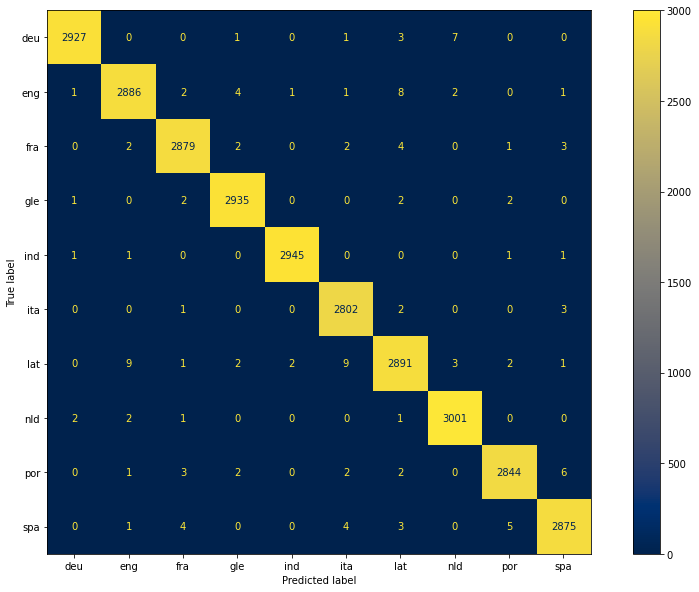

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cmp = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
fig, ax = plt.subplots(figsize=(15,10))
cmp.plot(cmap='cividis', ax=ax, values_format='')

In [ ]:
def predict(text):
  clean = regex_filter(text)
  x = word_vector(word_tokenize(clean), 200)
  lang = model.predict(x)
  pred = np.zeros_like(lang)
  pred[np.arange(len(lang)), lang.argmax(1)] = 1
  pred_lang = encoder.inverse_transform(pred)
  print(pred_lang[0])

In [ ]:
predict("ada garansi resmi nyaman dipakai lama koneksi bluetooth kuat suaranya jernih desainnya modern")

ind


In [ ]:
encoder.classes_

array(['deu', 'eng', 'fra', 'gle', 'ind', 'ita', 'lat', 'nld', 'por',
       'spa'], dtype='<U3')